In [167]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
%matplotlib inline


Read in the Data 

In [168]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()




/var/folders/7p/v4s1vzgj3fz1cnk_dqbddljr0000gn/T/ipykernel_90474/2462508884.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({"M","B"},{1,0})


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
492,18.01,20.56,118.40,1007.0,0.10010,0.1289,0.11700,0.07762,0.2116,0.06077,...,21.53,26.06,143.40,1426.0,0.1309,0.2327,0.2544,0.14890,0.3251,0.07625
211,11.84,18.94,75.51,428.0,0.08871,0.0690,0.02669,0.01393,0.1533,0.06057,...,13.30,24.99,85.22,546.3,0.1280,0.1880,0.1471,0.06913,0.2535,0.07993
536,14.27,22.55,93.77,629.8,0.10380,0.1154,0.14630,0.06139,0.1926,0.05982,...,15.29,34.27,104.30,728.3,0.1380,0.2733,0.4234,0.13620,0.2698,0.08351
460,17.08,27.15,111.20,930.9,0.09898,0.1110,0.10070,0.06431,0.1793,0.06281,...,22.96,34.49,152.10,1648.0,0.1600,0.2444,0.2639,0.15550,0.3010,0.09060
16,14.68,20.13,94.74,684.5,0.09867,0.0720,0.07395,0.05259,0.1586,0.05922,...,19.07,30.88,123.40,1138.0,0.1464,0.1871,0.2914,0.16090,0.3029,0.08216


In [169]:
# check for null values 
data.isnull().sum().sum()

0

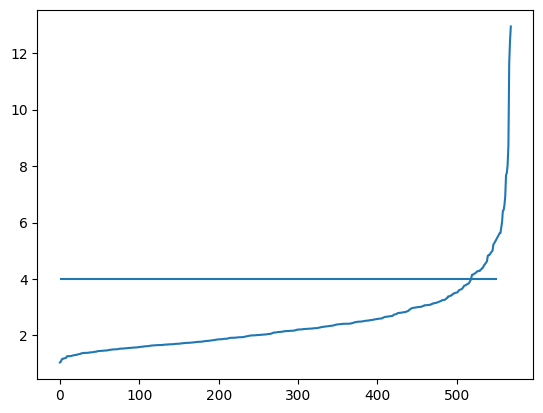

In [170]:
### Add preprocessing here (or inside the pipes)
## looking for outliers wit DBSCAN 
## finding besteps 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
plt.plot(distances)
plt.hlines(y=4, xmin=0, xmax=550)
# best eps around 3.75
plt.show()







In [171]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=4, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Y = Y[labels == 0]
X = X[labels == 0]
X.shape


Estimated no. of clusters: 2
Estimated no. of noise points: 31


(538, 30)

In [172]:
# Print metrics
from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [173]:
outputs = []


In [174]:


#Random Forest
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # mess with these
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,6,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("Chosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




Chosen max_depth: 34
Chosen min_samples_leaf: 1
Chosen max_depth: 33
Chosen min_samples_leaf: 1
Chosen max_depth: 30
Chosen min_samples_leaf: 3


In [ ]:
#ADA Boosting
param_grid = {
    'n_estimators': list(range(100,150,10)),
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



Chosen n_estimators: 140
Chosen n_estimators: 120
Chosen n_estimators: 110
Chosen n_estimators: 100
Chosen n_estimators: 130


In [ ]:
#SVM
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = {
    'pca__n_components': list(range(10, 15)),
    'svc__kernel': ["linear","rbf"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


Chosen n_components: 11
Chosen kernel: rbf
Chosen n_components: 13
Chosen kernel: linear
Chosen n_components: 10
Chosen kernel: linear
Chosen n_components: 14
Chosen kernel: linear
Chosen n_components: 10
Chosen kernel: linear


In [ ]:
#Nearest Neighbor
param_grid = { #mess with these
    'pca__n_components': list(range(7,13)),
    'knn__n_neighbors': list(range(3,7))
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



Chosen n_components: 11
Chosen n_neighbors: 3
Chosen n_components: 9
Chosen n_neighbors: 3
Chosen n_components: 8
Chosen n_neighbors: 5
Chosen n_components: 8
Chosen n_neighbors: 3
Chosen n_components: 11
Chosen n_neighbors: 5


In [ ]:
#Simple Neural Net
from sklearn import neural_network
scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = {
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,),(70,),(80,)],
    "nn__activation": ["logistic","tanh","relu"],
    "nn__max_iter" : [200,250,300,350]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("Chosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("Chosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



Chosen hidden_layer_sizes: (30,)
Chosen activation: logistic
Chosen max_iter: 250
Chosen hidden_layer_sizes: (40,)
Chosen activation: tanh
Chosen max_iter: 250
Chosen hidden_layer_sizes: (30,)
Chosen activation: relu
Chosen max_iter: 200
Chosen hidden_layer_sizes: (50,)
Chosen activation: relu
Chosen max_iter: 200
Chosen hidden_layer_sizes: (70,)
Chosen activation: tanh
Chosen max_iter: 300


In [ ]:
for output in outputs:
    print("Metrics for",output[0])
    PrintMetrics_list(output[1],output[2])
    print()

Metrics for Random Forest
Accuracy: 0.9628071997230876


,Predicted 1,Predicted 0
Actual 1,180,12
Actual 0,8,338


Precision:  0.9574468085106383
Recall: 0.9375

Metrics for ADA Boosting
Accuracy: 0.9720837660089996


,Predicted 1,Predicted 0
Actual 1,180,12
Actual 0,3,343


Precision:  0.9836065573770492
Recall: 0.9375

Metrics for SVM
Accuracy: 0.977673935617861


,Predicted 1,Predicted 0
Actual 1,184,8
Actual 0,4,342


Precision:  0.9787234042553191
Recall: 0.9583333333333334

Metrics for K Nearest Neighbor
Accuracy: 0.9608861197646243


,Predicted 1,Predicted 0
Actual 1,176,16
Actual 0,5,341


Precision:  0.9723756906077348
Recall: 0.9166666666666666

Metrics for Neural Nets
Accuracy: 0.9720491519556941


,Predicted 1,Predicted 0
Actual 1,184,8
Actual 0,7,339


Precision:  0.9633507853403142
Recall: 0.9583333333333334

Metrics for K Nearest Neighbor
Accuracy: 0.9553305642090688


,Predicted 1,Predicted 0
Actual 1,174,18
Actual 0,6,340


Precision:  0.9666666666666667
Recall: 0.90625

Metrics for K Nearest Neighbor
Accuracy: 0.9608861197646243


,Predicted 1,Predicted 0
Actual 1,176,16
Actual 0,5,341


Precision:  0.9723756906077348
Recall: 0.9166666666666666



In [ ]:
## save model here?